In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from yahoo_fin import stock_info as si
from collections import deque

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

from datetime import datetime
from datetime import date
import time

import pandas as pd
import numpy as np
import random
import os

In [2]:
#input in date for outputting stock price prediction
date_entry = input('Enter a date in the future you want to predict the stock price for "DD/MM/YYYY:"')
day, month, year = map(int, date_entry.split('/'))
a = date.today()
b = date(year,month,day)

Enter a date in the future you want to predict the stock price for "DD/MM/YYYY:"03/11/2021


In [3]:
# set seed
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [4]:
def shuffle_in_unison(a, b):
    
    # shuffle two arrays
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)


In [5]:

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    
    # check ticker
    if isinstance(ticker, str):
        
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
                        
    # contain elements we want to return from this function             
    result = {}
                        
    # return  original dataframe
    result['df'] = df.copy()
                        
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
                        
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
                        
        # scale prices from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
                        
        # MinMaxScaler
        result["column_scaler"] = column_scaler
                        
    # shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
                        
    # get `lookup_step` columns containing NaN in future column
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
                        
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
                        
    # used to predict future stock prices
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
                        
    # add to result
    result['last_sequence'] = last_sequence
                        
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
                        
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
                        
        # split the dataset into training & testing sets by date (no random splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
                        
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else: 
                        
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
                        
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
                        
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
                        
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [6]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
                
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [7]:
# Window size or the sequence length
N_STEPS = 50

# Lookup step, 1 is the next day
LOOKUP_STEP = (b-a).days

# scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"

# shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"

# split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"

# test ratio size = 20%
TEST_SIZE = 0.2

# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]

# date now
date_now = time.strftime("%Y-%m-%d")

# model parameters
N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# bidirectional RNNs
BIDIRECTIONAL = False

#training parameters

# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64

EPOCHS = 30
'''
EPOCHS is set to 30 for convinience. This is not ideal but will make the code run much faster.
You can change it to 300 if you like.
'''

# Stock data for the assignment
ticker = "TSLA"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")

# model name to save
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [8]:
# create folders
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [9]:
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

# tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

# train the model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/30
35/35 [==============================] - 8s 190ms/step - loss: 0.0045 - mean_absolute_error: 0.0435 - val_loss: 8.3912e-04 - val_mean_absolute_error: 0.0164

Epoch 00001: val_loss improved from inf to 0.00084, saving model to results\2021-10-18_TSLA-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-16-layers-2-units-256.h5
Epoch 2/30
35/35 [==============================] - 6s 164ms/step - loss: 9.3873e-04 - mean_absolute_error: 0.0203 - val_loss: 8.5928e-04 - val_mean_absolute_error: 0.0197

Epoch 00002: val_loss did not improve from 0.00084
Epoch 3/30
35/35 [==============================] - 6s 167ms/step - loss: 9.4699e-04 - mean_absolute_error: 0.0208 - val_loss: 6.0013e-04 - val_mean_absolute_error: 0.0161

Epoch 00003: val_loss improved from 0.00084 to 0.00060, saving model to results\2021-10-18_TSLA-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-16-layers-2-units-256.h5
Epoch 4/30
35/35 [==============================] - 6s 166ms/step - loss: 8.0760e-04 - mean_absolu

In [10]:
def plot_graph(test_df):
    '''
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    '''
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [11]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [12]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [13]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [14]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)

# calculate mea (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [15]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [16]:
# predict the future price
future_price = predict(model, data)

In [17]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)

# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()

# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit

# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

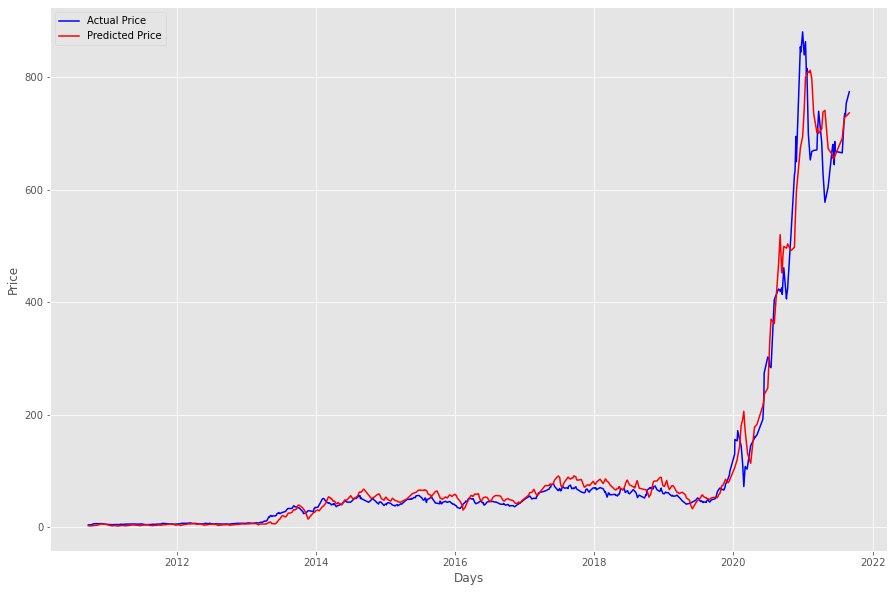

In [18]:
# plot a graph consisting of actual and predicted prices

%matplotlib inline

mpl.rc('figure', figsize=(15, 10))
mpl.__version__

style.use('ggplot')
plot_graph(final_df)


In [19]:
# printing important metrics
print(f"Predicted price after {LOOKUP_STEP} days is {future_price:.2f}$")
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)


Predicted price after 16 days is 796.32$
Mean Absolute Error: 17.321522709558213
Accuracy score: 0.5116696588868941


In [20]:
# save the final dataframe to csv-results folder
csv_results_folder = "DAVE3625_Assignment2"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)